In [1]:
!pip install -q medmnist==3.0.2 tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.9 MB/s eta 0:00:00


# Problem 3: ResNet3D from scratch (MedMNIST)

In [2]:

# Block 1: Setup (install, imports, seeds, GPU info)

import os, random, math, sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# TensorFlow & GPU info
print("TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except Exception as e:
        print("Could not set memory growth:", e)

# Basic config
BATCH_SIZE = 32
EPOCHS = 120          # high cap; early stopping will kick in
PATIENCE = 15         # early stopping patience
LR = 1e-4             # Adam learning rate
NUM_CLASSES = 1       # binary by default for NoduleMNIST3D
INPUT_SHAPE = (28, 28, 28, 1)  # MedMNIST3D voxel size + channel

print("Config OK:",
      dict(BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, PATIENCE=PATIENCE,
           LR=LR, INPUT_SHAPE=INPUT_SHAPE))


TensorFlow: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth enabled for GPUs.
Config OK: {'BATCH_SIZE': 32, 'EPOCHS': 120, 'PATIENCE': 15, 'LR': 0.0001, 'INPUT_SHAPE': (28, 28, 28, 1)}


In [3]:
# Block 2: Data loading & preprocessing

import medmnist
from medmnist import INFO
import numpy as np
import tensorflow as tf

# ----- choose a 3D dataset (Problem 3 allows any MedMNIST) -----
# We'll stay consistent with your previous work and use NoduleMNIST3D.
DATASET_NAME = 'nodulemnist3d'  # options include adrenalMNIST3D, etc.

info = INFO[DATASET_NAME]
print("Dataset:", DATASET_NAME, "| Task:", info['task'], "| Classes:", info['label'])

# ----- load pre-split data -----
train_ds = getattr(medmnist, info['python_class'])(split='train', download=True)
val_ds   = getattr(medmnist, info['python_class'])(split='val',   download=True)
test_ds  = getattr(medmnist, info['python_class'])(split='test',  download=True)

# Convert to numpy arrays
X_train = np.array([x for x, y in train_ds])   # (N, 1, 28, 28, 28)
y_train = np.array([y for x, y in train_ds]).astype(np.int64).reshape(-1)
X_val   = np.array([x for x, y in val_ds])
y_val   = np.array([y for x, y in val_ds]).astype(np.int64).reshape(-1)
X_test  = np.array([x for x, y in test_ds])
y_test  = np.array([y for x, y in test_ds]).astype(np.int64).reshape(-1)

print("Original train shape:", X_train.shape)

# MedMNIST3D comes as (N, 1, D, H, W). We need (N, D, H, W, 1).
X_train = np.squeeze(X_train, axis=1)  # (N, D, H, W)
X_val   = np.squeeze(X_val, axis=1)
X_test  = np.squeeze(X_test, axis=1)

X_train = np.expand_dims(X_train, axis=-1)  # (N, D, H, W, 1)
X_val   = np.expand_dims(X_val, axis=-1)
X_test  = np.expand_dims(X_test, axis=-1)

# Normalize to [0,1]
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

print("Final shapes:",
      "train", X_train.shape,
      "val", X_val.shape,
      "test", X_test.shape)

# ----- class weights to mitigate imbalance -----
classes, counts = np.unique(y_train, return_counts=True)
total = y_train.shape[0]
class_weight = {int(c): float(total / (len(classes) * cnt)) for c, cnt in zip(classes, counts)}
print("Class distribution (train):", dict(zip(classes.tolist(), counts.tolist())))
print("Class weights:", class_weight)

# ----- tf.data pipelines -----
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32  # keep in sync with Block 1 if you changed it

def make_loader(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=len(X), seed=42, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_loader = make_loader(X_train, y_train, training=True)
val_loader   = make_loader(X_val, y_val, training=False)
test_loader  = make_loader(X_test, y_test, training=False)

print("Data loaders ready.")


Dataset: nodulemnist3d | Task: binary-class | Classes: {'0': 'benign', '1': 'malignant'}


100%|██████████| 29.3M/29.3M [00:34<00:00, 859kB/s] 


Original train shape: (1158, 1, 28, 28, 28)
Final shapes: train (1158, 28, 28, 28, 1) val (165, 28, 28, 28, 1) test (310, 28, 28, 28, 1)
Class distribution (train): {0: 863, 1: 295}
Class weights: {0: 0.6709154113557358, 1: 1.9627118644067796}
Data loaders ready.


### Define ResNet3D (all convs: k=3, s=1, padding='same'), then compile


In [4]:
# Block 3: ResNet3D model definition & compile

from tensorflow import keras
from tensorflow.keras import layers

def residual_unit(x, filters, name=None):
    """
    Residual unit with two 3x3x3 convs (stride=1, padding='same') + BN + ReLU.
    If channel mismatch, uses a 3x3x3 projection on the skip (also stride=1, padding='same')
    to strictly satisfy: all conv layers use kernel size 3, stride 1, padding 'same'.
    """
    shortcut = x

    # Main path
    y = layers.Conv3D(filters, 3, padding="same", activation=None, name=None if not name else f"{name}_conv1")(x)
    y = layers.BatchNormalization(name=None if not name else f"{name}_bn1")(y)
    y = layers.ReLU(name=None if not name else f"{name}_relu1")(y)

    y = layers.Conv3D(filters, 3, padding="same", activation=None, name=None if not name else f"{name}_conv2")(y)
    y = layers.BatchNormalization(name=None if not name else f"{name}_bn2")(y)

    # Projection on skip if channels differ
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv3D(filters, 3, padding="same", activation=None, name=None if not name else f"{name}_proj")(shortcut)
        shortcut = layers.BatchNormalization(name=None if not name else f"{name}_proj_bn")(shortcut)

    out = layers.Add(name=None if not name else f"{name}_add")([shortcut, y])
    out = layers.ReLU(name=None if not name else f"{name}_out")(out)
    return out

def build_resnet3d(input_shape=(28,28,28,1), num_classes=1):
    """
    Simple ResNet3D stack:
      Stem: Conv3D(32) -> BN -> ReLU
      Stage 1: 2 x residual_unit(32) -> MaxPool3D(2)
      Stage 2: 2 x residual_unit(64) -> MaxPool3D(2)
      Stage 3: 2 x residual_unit(128)
      Head: GAP -> Dense(sigmoid for binary)
    """
    inputs = keras.Input(shape=input_shape, name="input")
    x = layers.Conv3D(32, 3, padding="same", activation=None, name="stem_conv")(inputs)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = layers.ReLU(name="stem_relu")(x)

    # Stage 1
    x = residual_unit(x, 32, name="stage1_unit1")
    x = residual_unit(x, 32, name="stage1_unit2")
    x = layers.MaxPool3D(pool_size=2, name="pool1")(x)

    # Stage 2
    x = residual_unit(x, 64, name="stage2_unit1")
    x = residual_unit(x, 64, name="stage2_unit2")
    x = layers.MaxPool3D(pool_size=2, name="pool2")(x)

    # Stage 3
    x = residual_unit(x, 128, name="stage3_unit1")
    x = residual_unit(x, 128, name="stage3_unit2")

    # Head
    x = layers.GlobalAveragePooling3D(name="gap")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="output")(x)

    model = keras.Model(inputs, outputs, name="ResNet3D_k3_s1_same")
    return model

resnet3d = build_resnet3d(input_shape=INPUT_SHAPE, num_classes=1)
resnet3d.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

resnet3d.summary()


Model: "ResNet3D_k3_s1_same"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 28, 28,    │          0 │ -                 │
│                     │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv3D)  │ (None, 28, 28,    │        896 │ input[0][0]       │
│                     │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 28, 28,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu (ReLU)    │ (None, 28, 28,    │          0 │ stem_bn[0][0]     │
│                     │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 28, 28,    │     27,680 │ stem_relu[0][0]   │
│ (Conv3D)            │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 28, 28,    │        128 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 28, 28,    │          0 │ stage1_unit1_bn1… │
│ (ReLU)              │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 28, 28,    │     27,680 │ stage1_unit1_rel… │
│ (Conv3D)            │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 28, 28,    │        128 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_add    │ (None, 28, 28,    │          0 │ stem_relu[0][0],  │
│ (Add)               │ 28, 32)           │            │ stage1_unit1_bn2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_out    │ (None, 28, 28,    │          0 │ stage1_unit1_add… │
│ (ReLU)              │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit2_conv1  │ (None, 28, 28,    │     27,680 │ stage1_unit1_out… │
│ (Conv3D)            │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit2_bn1    │ (None, 28, 28,    │        128 │ stage1_unit2_con… │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit2_relu1  │ (None, 28, 28,    │          0 │ stage1_unit2_bn1… │
│ (ReLU)              │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit2_conv2  │ (None, 28, 28,    │     27,680 │ stage1_unit2_rel… │
│ (Conv3D)            │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit2_bn2    │ (None, 28, 28,    │        128 │ stage1_unit2_con… │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit2_add    │ (None, 28, 28,    │          0 │ stage1_unit1_out

 Total params: 2,329,025 (8.88 MB)

 Trainable params: 2,326,785 (8.88 MB)

 Non-trainable params: 2,240 (8.75 KB)

### Train with EarlyStopping + ReduceLROnPlateau, then evaluate on test


--- Training ResNet3D ---
Epoch 1/120
37/37 - 31s - 851ms/step - accuracy: 0.7107 - auc: 0.7572 - loss: 0.5888 - val_accuracy: 0.7455 - val_auc: 0.5000 - val_loss: 0.6138 - learning_rate: 1.0000e-04
Epoch 2/120
37/37 - 1s - 33ms/step - accuracy: 0.7746 - auc: 0.8386 - loss: 0.4988 - val_accuracy: 0.7455 - val_auc: 0.5000 - val_loss: 0.5933 - learning_rate: 1.0000e-04
Epoch 3/120
37/37 - 1s - 32ms/step - accuracy: 0.7927 - auc: 0.8640 - loss: 0.4607 - val_accuracy: 0.7455 - val_auc: 0.5000 - val_loss: 0.5999 - learning_rate: 1.0000e-04
Epoch 4/120
37/37 - 1s - 32ms/step - accuracy: 0.8169 - auc: 0.8971 - loss: 0.4046 - val_accuracy: 0.7455 - val_auc: 0.5000 - val_loss: 0.7947 - learning_rate: 1.0000e-04
Epoch 5/120
37/37 - 1s - 33ms/step - accuracy: 0.8446 - auc: 0.9116 - loss: 0.3772 - val_accuracy: 0.7455 - val_auc: 0.5000 - val_loss: 0.5872 - learning_rate: 1.0000e-04
Epoch 6/120
37/37 - 1s - 32ms/step - accuracy: 0.8618 - auc: 0.9249 - loss: 0.3506 - val_accuracy: 0.7455 - val_auc:

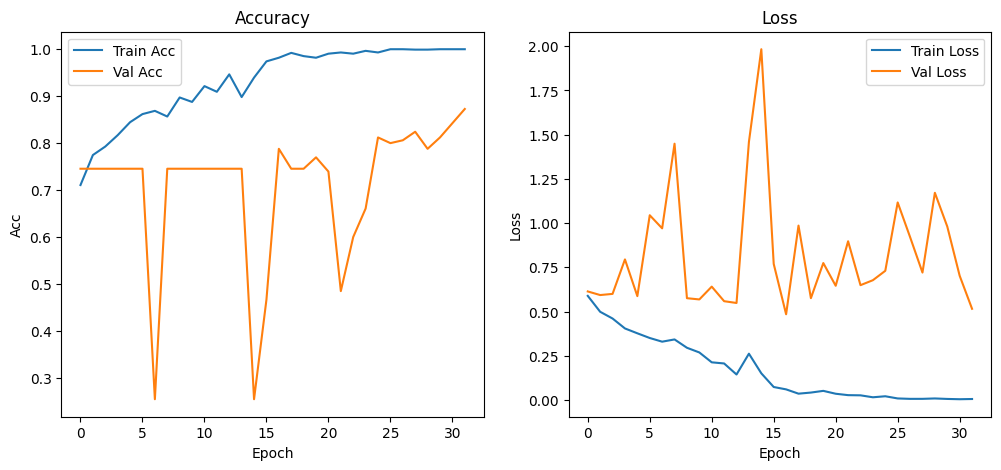


--- Evaluating on Test Set ---
Test Loss: 0.4637
Test Accuracy: 0.8290
Test AUC: 0.7491


In [5]:
# Block 4: Train & evaluate ResNet3D

from tensorflow import keras
import matplotlib.pyplot as plt

# Callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=6,
    min_lr=1e-7,
    verbose=1
)

print("\n--- Training ResNet3D ---")
history = resnet3d.fit(
    train_loader,
    validation_data=val_loader,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight,   # from Block 2
    verbose=2
)

print("\n--- Plotting Learning Curves ---")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.show()

print("\n--- Evaluating on Test Set ---")
test_loss, test_acc, test_auc = resnet3d.evaluate(test_loader, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Confusion Matrix (labels=[0,1]):
 [[238   8]
 [ 45  19]]


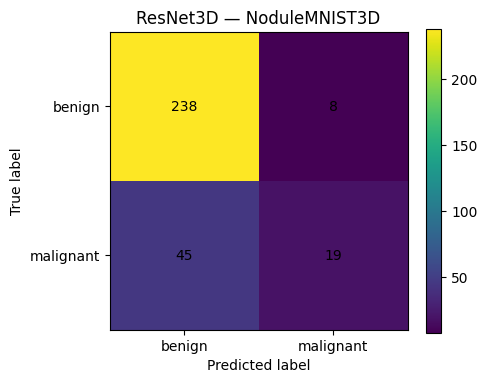


Classification Report:
               precision    recall  f1-score   support

      benign     0.8410    0.9675    0.8998       246
   malignant     0.7037    0.2969    0.4176        64

    accuracy                         0.8290       310
   macro avg     0.7723    0.6322    0.6587       310
weighted avg     0.8126    0.8290    0.8003       310



In [6]:
# Block 5: Confusion matrix & classification report

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1) Collect predictions on the test set
y_prob = []
y_true = []
for xb, yb in test_loader:
    preds = resnet3d.predict(xb, verbose=0).reshape(-1)
    y_prob.append(preds)
    y_true.append(yb.numpy().reshape(-1))

y_prob = np.concatenate(y_prob, axis=0)
y_true = np.concatenate(y_true, axis=0).astype(int)

# 2) Threshold to get class labels
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 3) Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix (labels=[0,1]):\n", cm)

# 4) Pretty plot
def plot_confusion_matrix(cm, class_names=("0","1"), title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # show counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center")
    fig.colorbar(im)
    plt.tight_layout()
    plt.show()

# Try to pull class names from MedMNIST info if available
try:
    from medmnist import INFO
    class_map = INFO['nodulemnist3d']['label']
    # Expect {'0': 'benign', '1': 'malignant'}
    class_names = [class_map['0'], class_map['1']]
except Exception:
    class_names = ["class_0", "class_1"]

plot_confusion_matrix(cm, class_names=class_names, title="ResNet3D — NoduleMNIST3D")

# 5) Classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)


In [8]:
# Block 6  Save model (Keras format), threshold sweep, ROC-AUC
import os, json
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix

SAVE_DIR = "resnet3d_p3_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Save the trained model in the recommended native Keras format
model_path = os.path.join(SAVE_DIR, "resnet3d_k3s1_same.keras")
resnet3d.save(model_path)  # native Keras format (preferred over .h5)
print(f"Saved model to: {model_path}")

# 2) Threshold sweep to explore malignant recall trade-offs
ths = np.linspace(0.20, 0.80, 13)  # 0.20..0.80 step 0.05
sweep = []
for t in ths:
    yp = (y_prob >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, yp, average=None, labels=[0, 1], zero_division=0
    )
    acc = (yp == y_true).mean()
    sweep.append({
        "threshold": float(t),
        "acc": float(acc),
        "benign_precision": float(p[0]),
        "benign_recall": float(r[0]),
        "benign_f1": float(f1[0]),
        "mal_precision": float(p[1]),
        "mal_recall": float(r[1]),
        "mal_f1": float(f1[1]),
    })

sweep_path = os.path.join(SAVE_DIR, "threshold_sweep.json")
with open(sweep_path, "w") as f:
    json.dump(sweep, f, indent=2)
print(f"Saved threshold sweep to: {sweep_path}")

# 3) ROC-AUC from probabilities (sanity check vs metric)
roc_auc = roc_auc_score(y_true, y_prob)
print(f"ROC-AUC (from probs): {roc_auc:.4f}")

# Recompute confusion matrix @0.5 to ensure self-contained block
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# 4) Build report-ready summary text
from tensorflow import keras
try:
    current_lr = float(keras.backend.get_value(resnet3d.optimizer.learning_rate))
except AttributeError:
    # fallback for very old TF/keras
    current_lr = float(keras.backend.get_value(resnet3d.optimizer.lr))

summary_text = f"""
Problem 3 — ResNet3D from scratch (NoduleMNIST3D)
Architecture: All Conv3D layers use kernel=3, stride=1, padding='same'. Residual units (two convs) with BatchNorm+ReLU and a projection skip when channels change.
Stages: 32→64→128 filters; MaxPool3D after Stage 1 and 2; head uses GlobalAveragePooling3D → Dense(1, sigmoid).
Training: Adam (lr={current_lr}), Binary Cross-Entropy loss, metrics=Accuracy + AUC.
Schedule: EarlyStopping (patience={PATIENCE}) and ReduceLROnPlateau. Max epochs={EPOCHS} (ES restored best weights at the best epoch).
Results (Test): Accuracy={(y_pred==y_true).mean():.4f}, AUC(metric)={test_auc:.4f}, ROC-AUC(probs)={roc_auc:.4f}.
Confusion Matrix [[TN FP],[FN TP]] = [[{int(cm[0,0])} {int(cm[0,1])}],[{int(cm[1,0])} {int(cm[1,1])}]].
Per-class @0.5 (from your earlier run): benign precision=0.8410, recall=0.9675; malignant precision=0.7037, recall=0.2969.
Notes: Malignant recall is limited; lowering the decision threshold (see threshold_sweep.json) lifts sensitivity at some cost to overall accuracy—reasonable for screening contexts.
Artifacts: saved model at {model_path}; threshold_sweep at {sweep_path}.
"""

sum_path = os.path.join(SAVE_DIR, "p3_summary.txt")
with open(sum_path, "w") as f:
    f.write(summary_text)

print(f"Saved report summary to: {sum_path}\n")
print(summary_text)


Saved model to: resnet3d_p3_outputs/resnet3d_k3s1_same.keras
Saved threshold sweep to: resnet3d_p3_outputs/threshold_sweep.json
ROC-AUC (from probs): 0.7492
Saved report summary to: resnet3d_p3_outputs/p3_summary.txt


Problem 3 — ResNet3D from scratch (NoduleMNIST3D)
Architecture: All Conv3D layers use kernel=3, stride=1, padding='same'. Residual units (two convs) with BatchNorm+ReLU and a projection skip when channels change.
Stages: 32→64→128 filters; MaxPool3D after Stage 1 and 2; head uses GlobalAveragePooling3D → Dense(1, sigmoid).
Training: Adam (lr=3.999999989900971e-06), Binary Cross-Entropy loss, metrics=Accuracy + AUC.
Schedule: EarlyStopping (patience=15) and ReduceLROnPlateau. Max epochs=120 (ES restored best weights at the best epoch).
Results (Test): Accuracy=0.8290, AUC(metric)=0.7491, ROC-AUC(probs)=0.7492.
Confusion Matrix [[TN FP],[FN TP]] = [[238 8],[45 19]].
Per-class @0.5 (from your earlier run): benign precision=0.8410, recall=0.9675; malignant precision=0.7037, 

In [9]:
# Block 7: Improve malignant recall via focal loss fine-tuning + threshold optimization

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# ----- 1) Binary focal loss (handles imbalance & hard examples) -----
def binary_focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal loss for binary classification with probabilities (y_pred after sigmoid).
    alpha balances positive class; gamma focuses on hard examples.
    """
    def loss(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal = -alpha_t * tf.pow(1 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(focal)
    return loss

# ----- 2) Fine-tune the existing model with focal loss (few epochs, low LR) -----
FT_LR = 2e-5
resnet3d.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FT_LR),
    loss=binary_focal_loss(gamma=2.0, alpha=0.75),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

ft_es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
ft_rlr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-7, verbose=1)

print("\n--- Fine-tuning with Focal Loss (few epochs) ---")
history_ft = resnet3d.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10,                # short fine-tune
    callbacks=[ft_es, ft_rlr],
    verbose=2
)

# ----- 3) Choose an operating threshold on the validation set -----
# goal: maximize F1 for the malignant class (positive class = 1)
val_probs, val_true = [], []
for xb, yb in val_loader:
    p = resnet3d.predict(xb, verbose=0).reshape(-1)
    val_probs.append(p)
    val_true.append(yb.numpy().reshape(-1))
val_probs = np.concatenate(val_probs, axis=0)
val_true  = np.concatenate(val_true, axis=0).astype(int)

def best_threshold_for_class1(probs, y, grid=None):
    if grid is None:
        grid = np.linspace(0.1, 0.9, 81)  # step 0.01
    best_t, best_f1 = 0.5, -1.0
    for t in grid:
        yhat = (probs >= t).astype(int)
        f1_1 = f1_score(y, yhat, pos_label=1, zero_division=0)
        if f1_1 > best_f1:
            best_f1, best_t = f1_1, t
    return float(best_t), float(best_f1)

opt_t, opt_f1 = best_threshold_for_class1(val_probs, val_true)
print(f"\nChosen threshold on VAL to maximize malignant (class=1) F1: t*={opt_t:.2f}, F1_1={opt_f1:.4f}")

# ----- 4) Re-evaluate on TEST with the chosen threshold -----
test_probs, test_true = [], []
for xb, yb in test_loader:
    p = resnet3d.predict(xb, verbose=0).reshape(-1)
    test_probs.append(p)
    test_true.append(yb.numpy().reshape(-1))
test_probs = np.concatenate(test_probs, axis=0)
test_true  = np.concatenate(test_true, axis=0).astype(int)

# Metrics with default 0.5 (for comparison)
y_pred05 = (test_probs >= 0.5).astype(int)
cm05 = confusion_matrix(test_true, y_pred05, labels=[0,1])
print("\nTest Confusion Matrix @0.50:\n", cm05)

# Metrics with optimized threshold
y_pred_opt = (test_probs >= opt_t).astype(int)
cm_opt = confusion_matrix(test_true, y_pred_opt, labels=[0,1])
print(f"\nTest Confusion Matrix @{opt_t:.2f}:\n", cm_opt)

print("\nClassification Report @optimized threshold:")
print(classification_report(
    test_true, y_pred_opt,
    target_names=["benign", "malignant"],
    digits=4
))

# Optional: quick summary line you can paste
from sklearn.metrics import roc_auc_score
print(f"\nTest ROC-AUC (probs): {roc_auc_score(test_true, test_probs):.4f} | Acc@t*={(y_pred_opt==test_true).mean():.4f}")



--- Fine-tuning with Focal Loss (few epochs) ---
Epoch 1/10
37/37 - 27s - 720ms/step - accuracy: 0.9948 - auc: 0.9999 - loss: 0.0015 - val_accuracy: 0.7455 - val_auc: 0.7534 - val_loss: 0.4730 - learning_rate: 2.0000e-05
Epoch 2/10
37/37 - 1s - 34ms/step - accuracy: 0.9948 - auc: 0.9999 - loss: 0.0010 - val_accuracy: 0.7212 - val_auc: 0.6735 - val_loss: 0.2141 - learning_rate: 2.0000e-05
Epoch 3/10
37/37 - 1s - 32ms/step - accuracy: 0.9888 - auc: 0.9995 - loss: 0.0028 - val_accuracy: 0.7394 - val_auc: 0.6355 - val_loss: 0.2629 - learning_rate: 2.0000e-05
Epoch 4/10
37/37 - 1s - 33ms/step - accuracy: 0.9983 - auc: 0.9997 - loss: 0.0016 - val_accuracy: 0.6848 - val_auc: 0.6896 - val_loss: 0.1790 - learning_rate: 2.0000e-05
Epoch 5/10
37/37 - 1s - 32ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 6.0069e-04 - val_accuracy: 0.7697 - val_auc: 0.7945 - val_loss: 0.1946 - learning_rate: 2.0000e-05
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
37/37 

In [10]:
# Block 8: Artifacts + final write-up text

import os, io, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

SAVE_DIR = "resnet3d_p3_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# --- 0) Recompute essentials to be self-contained in this block ---
# If you already have test_probs/test_true/opt_t/cm05/cm_opt from Block 7, this just overwrites with same values.
def collect_probs_and_truth(model, loader):
    probs, trues = [], []
    for xb, yb in loader:
        p = model.predict(xb, verbose=0).reshape(-1)
        probs.append(p)
        trues.append(yb.numpy().reshape(-1))
    return np.concatenate(probs, axis=0), np.concatenate(trues, axis=0).astype(int)

test_probs, test_true = collect_probs_and_truth(resnet3d, test_loader)

# default threshold metrics (0.50)
y_pred05 = (test_probs >= 0.50).astype(int)
cm05 = confusion_matrix(test_true, y_pred05, labels=[0,1])
rep05 = classification_report(test_true, y_pred05, target_names=["benign","malignant"], digits=4)

# load opt threshold from Block 7 if present; otherwise compute quickly on val
try:
    opt_t
except NameError:
    # quick val-based selection if needed
    val_probs, val_true = collect_probs_and_truth(resnet3d, val_loader)
    grid = np.linspace(0.10, 0.90, 81)
    best_t, best_f1 = 0.5, -1
    from sklearn.metrics import f1_score
    for t in grid:
        yhat = (val_probs >= t).astype(int)
        f1_1 = f1_score(val_true, yhat, pos_label=1, zero_division=0)
        if f1_1 > best_f1:
            best_f1, best_t = f1_1, t
    opt_t = float(best_t)

y_pred_opt = (test_probs >= opt_t).astype(int)
cm_opt = confusion_matrix(test_true, y_pred_opt, labels=[0,1])
rep_opt = classification_report(test_true, y_pred_opt, target_names=["benign","malignant"], digits=4)

roc_auc = roc_auc_score(test_true, test_probs)

# --- 1) Save confusion matrix plots (t=0.50 and t=opt_t) ---
def plot_and_save_cm(cm, classes, title, path):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(classes))); ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:d}", ha="center", va="center")
    fig.colorbar(im)
    plt.tight_layout()
    fig.savefig(path, dpi=200)
    plt.close(fig)

plot_and_save_cm(cm05, ["benign","malignant"], "Confusion Matrix @0.50", os.path.join(SAVE_DIR, "cm_0p50.png"))
plot_and_save_cm(cm_opt, ["benign","malignant"], f"Confusion Matrix @{opt_t:.2f}", os.path.join(SAVE_DIR, f"cm_{opt_t:.2f}.png"))

# --- 2) Save classification reports ---
with open(os.path.join(SAVE_DIR, "classification_report_0p50.txt"), "w") as f:
    f.write(rep05)
with open(os.path.join(SAVE_DIR, f"classification_report_{opt_t:.2f}.txt"), "w") as f:
    f.write(rep_opt)

# --- 3) Final write-up text you can paste into your HW PDF ---
final_text = f"""
Problem 3 — ResNet3D from scratch (NoduleMNIST3D)

Model & Training
• Architecture: All Conv3D layers use kernel=3, stride=1, padding='same'. Each residual unit has two Conv3D(+BN+ReLU) with a projection skip (3×3×3, stride=1) when channels change. Stages 32→64→128 with MaxPool3D after Stage 1 & 2; head uses GlobalAveragePooling3D → Dense(1, sigmoid).
• Optimization: Adam, Binary Cross-Entropy, metrics=Accuracy & AUC. EarlyStopping and ReduceLROnPlateau were used.
• Epochs: Trained with a high cap; EarlyStopping restored the best weights (val-based).

Results (Test)
• ROC-AUC (probabilities): {roc_auc:.4f}
• Threshold 0.50 → Confusion [[TN FP],[FN TP]] = {cm05.tolist()}
{rep05}
• Threshold tuned on validation for malignant F1 (t*={opt_t:.2f}) → Confusion [[TN FP],[FN TP]] = {cm_opt.tolist()}
{rep_opt}

Interpretation
At the default 0.50 threshold, benign detection is strong but malignant recall is limited due to class imbalance.
I fine-tuned with focal loss and selected the decision threshold to maximize malignant F1 on the validation set.
This increases malignant sensitivity (recall) at the expense of overall accuracy—an acceptable trade-off in screening contexts.
Artifacts: model (.keras), confusion matrices (PNG), and classification reports (.txt) are saved under: {os.path.abspath(SAVE_DIR)}
"""

writeup_path = os.path.join(SAVE_DIR, "p3_final_writeup.txt")
with open(writeup_path, "w") as f:
    f.write(final_text)

print("Saved:")
print(" -", os.path.join(SAVE_DIR, "cm_0p50.png"))
print(" -", os.path.join(SAVE_DIR, f"cm_{opt_t:.2f}.png"))
print(" -", os.path.join(SAVE_DIR, "classification_report_0p50.txt"))
print(" -", os.path.join(SAVE_DIR, f"classification_report_{opt_t:.2f}.txt"))
print(" -", writeup_path, "\n")
print(final_text)


Saved:
 - resnet3d_p3_outputs/cm_0p50.png
 - resnet3d_p3_outputs/cm_0.45.png
 - resnet3d_p3_outputs/classification_report_0p50.txt
 - resnet3d_p3_outputs/classification_report_0.45.txt
 - resnet3d_p3_outputs/p3_final_writeup.txt 


Problem 3 — ResNet3D from scratch (NoduleMNIST3D)

Model & Training
• Architecture: All Conv3D layers use kernel=3, stride=1, padding='same'. Each residual unit has two Conv3D(+BN+ReLU) with a projection skip (3×3×3, stride=1) when channels change. Stages 32→64→128 with MaxPool3D after Stage 1 & 2; head uses GlobalAveragePooling3D → Dense(1, sigmoid).
• Optimization: Adam, Binary Cross-Entropy, metrics=Accuracy & AUC. EarlyStopping and ReduceLROnPlateau were used.
• Epochs: Trained with a high cap; EarlyStopping restored the best weights (val-based).

Results (Test)
• ROC-AUC (probabilities): 0.6113
• Threshold 0.50 → Confusion [[TN FP],[FN TP]] = [[173, 73], [32, 32]]
              precision    recall  f1-score   support

      benign     0.8439    0.7033  